# Experiments and results

In [ ]:
from utils import prox_mcp, mcp, mcp_torch

from experiments import (
    run_experiment, plot_scaling, plot_images, plot_loss, plot_smoothing_loss,
    plot_primal_gap_and_penalty, plot_images_ranks,
)

import numpy as np
import torch


## Chose the dataset

Uncomment the line corresponding to the dataset you want to use

In [2]:
dataset = 'camera'
# dataset = "olivetti" 
# dataset = "camera"
# dataset = "spectrometer"
# dataset = "football"
# dataset = "miserables"
# dataset = "low_rank_synthetic"

K = 10_000 if dataset == 'olivetti' else 5_000
store_WH_every = 100 if dataset == 'olivetti' else 1
g = lambda W : np.sum(mcp(W))
g_torch = lambda W : torch.sum(mcp_torch(W))
prox = prox_mcp

## Dataset

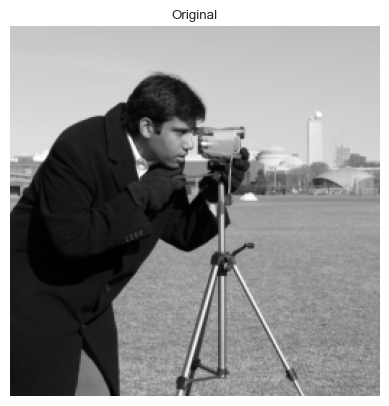

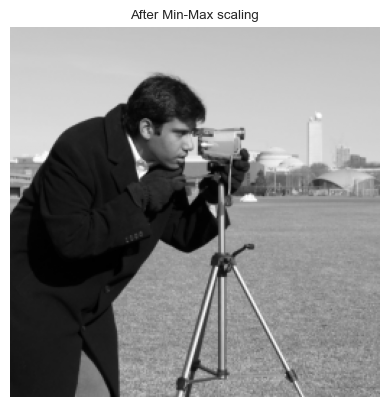

Dataset shape: (256, 256)


In [3]:
plot_scaling(dataset)

## Experiments with rank = 10

### Run algorithms

In [4]:
results10 = run_experiment(
    dataset, 
    rank = 10, 
    K = K, 
    g = g,
    g_torch = g_torch,
    prox = prox,
    store_WH_every = store_WH_every,
)

100%|██████████| 5000/5000 [00:02<00:00, 2227.75it/s]


Gamons (p = 2/3. q = 1/4) loss: 311.7851512926411


100%|██████████| 5000/5000 [00:01<00:00, 4005.82it/s]


Gamons (p = 7/12. q = 1/3) loss: 311.836480129271


100%|██████████| 5000/5000 [00:02<00:00, 2477.29it/s]


Subgradient descent loss: 323.6020812988281


100%|██████████| 5000/5000 [00:00<00:00, 5621.36it/s]

Variable Smoothing BW loss: 313.8079643564872


### Show the final images

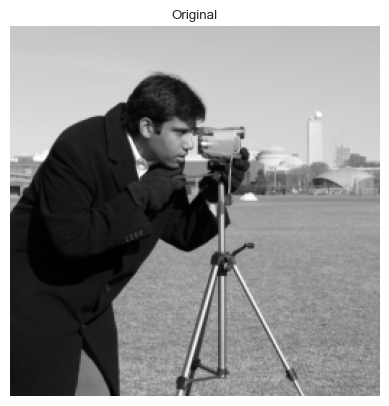

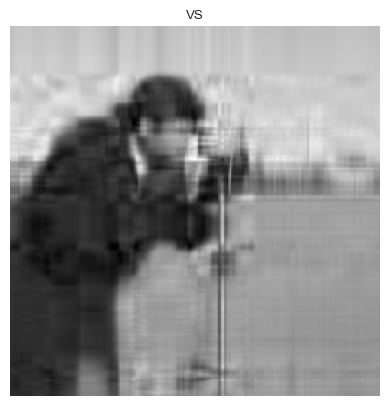

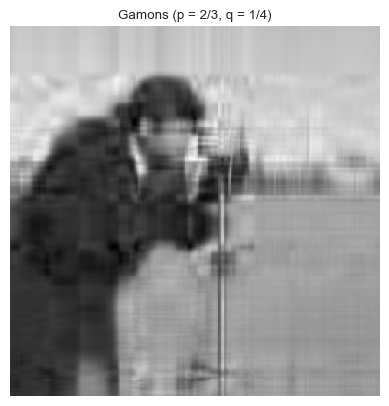

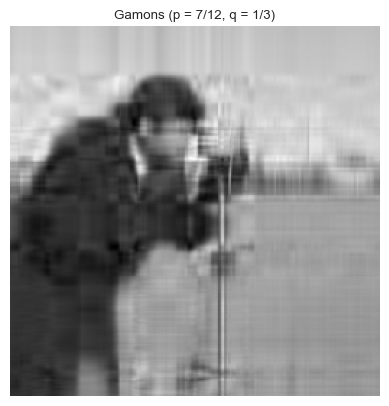

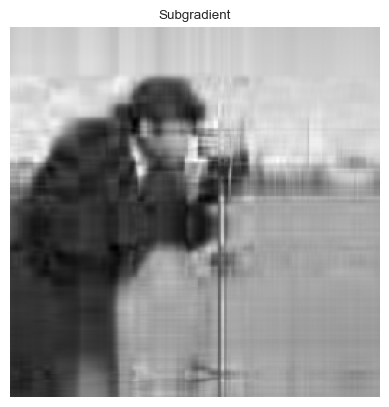

In [5]:
plot_images(results10)

### Plot the reconstruction loss

VS : 1.429e-02
GAMONS (p = 2/3. q = 1/4) : 1.419e-02
GAMONS (p = 7/12. q = 1/3) : 1.420e-02
Subgradient : 1.473e-02


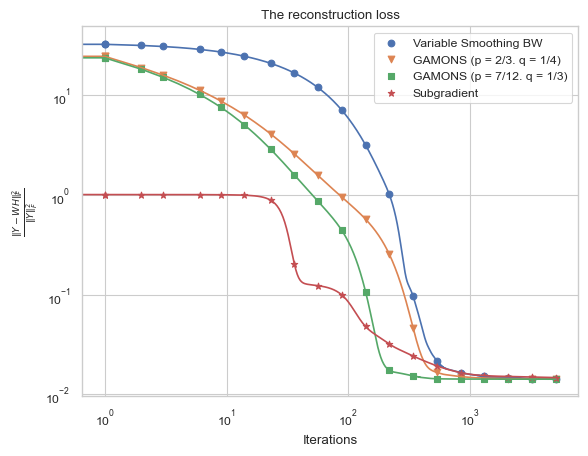

In [6]:
plot_loss(results10)

### Plot the smoothing loss

VS : 9.828e-05
GAMONS (p = 2/3. q = 1/4) : 1.213e-04
GAMONS (p = 7/12. q = 1/3) : 6.632e-05


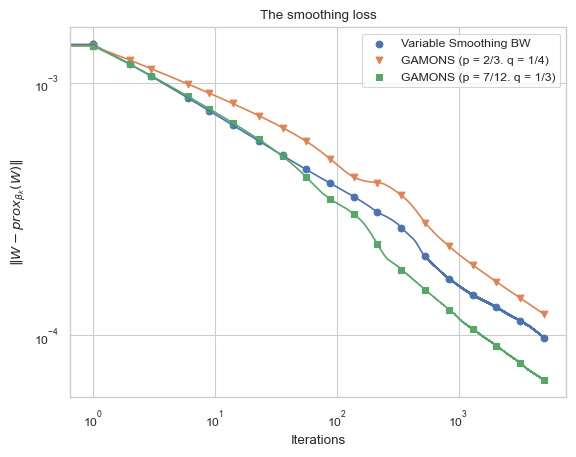

In [7]:
plot_smoothing_loss(results10)

### Plot the primal gap and penalty

VS : -2.877e+04
GAMONS (p = 2/3. q = 1/4) : -2.882e+04
GAMONS (p = 7/12. q = 1/3) : -2.886e+04
[ -7015.76378002  -7025.11935599  -7034.49317145 ... -28715.6755174
 -28715.68589063 -28715.70344874]


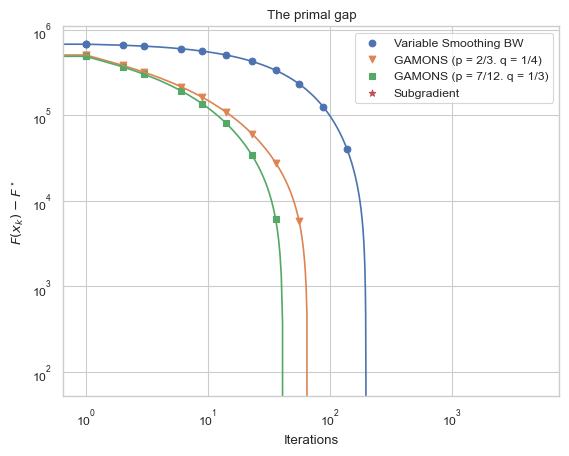

VS : 1.602e+02
GAMONS (p = 2/3. q = 1/4) : 1.153e+02
GAMONS (p = 7/12. q = 1/3) : 7.239e+01


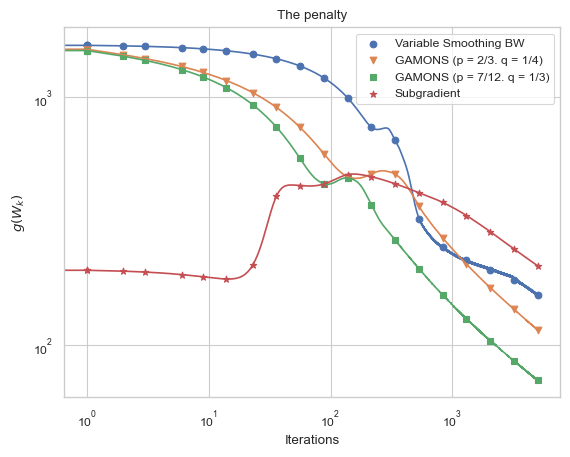

In [8]:
plot_primal_gap_and_penalty(results10)


## Experiments with rank = 20

### Run algorithms

In [9]:
results20 = run_experiment(
    dataset, 
    rank = 20, 
    K = K, 
    g = g, 
    g_torch = g_torch,
    prox = prox,
)

100%|██████████| 5000/5000 [00:01<00:00, 2565.24it/s]


Gamons (p = 2/3. q = 1/4) loss: 145.8970348191447


100%|██████████| 5000/5000 [00:02<00:00, 2454.80it/s]


Gamons (p = 7/12. q = 1/3) loss: 146.21598158612866


100%|██████████| 5000/5000 [00:02<00:00, 2336.65it/s]


Subgradient descent loss: 177.6646728515625


100%|██████████| 5000/5000 [00:01<00:00, 4115.51it/s]

Variable Smoothing BW loss: 154.68648567234928


### Show the final images

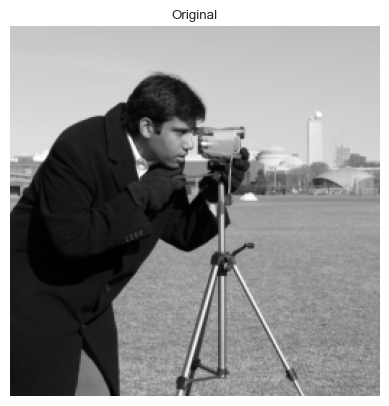

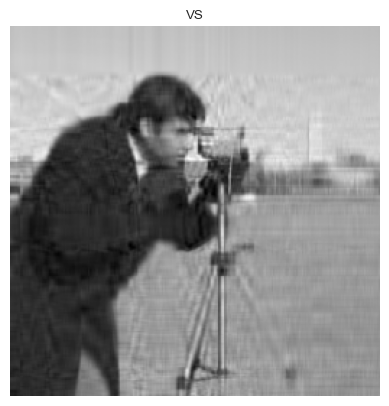

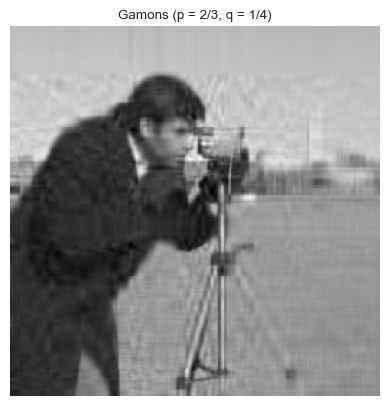

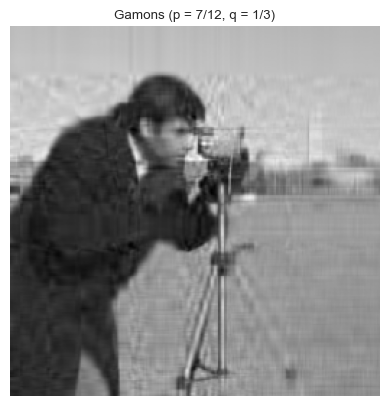

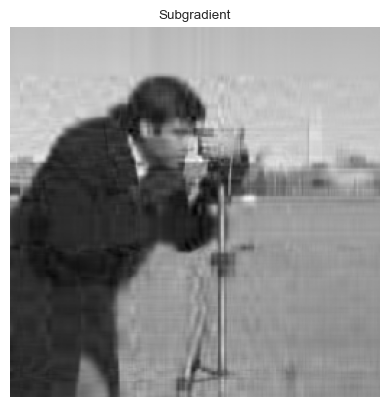

In [10]:
plot_images(results20)

### Plot the reconstruction loss

VS : 7.042e-03
GAMONS (p = 2/3. q = 1/4) : 6.642e-03
GAMONS (p = 7/12. q = 1/3) : 6.656e-03
Subgradient : 8.088e-03


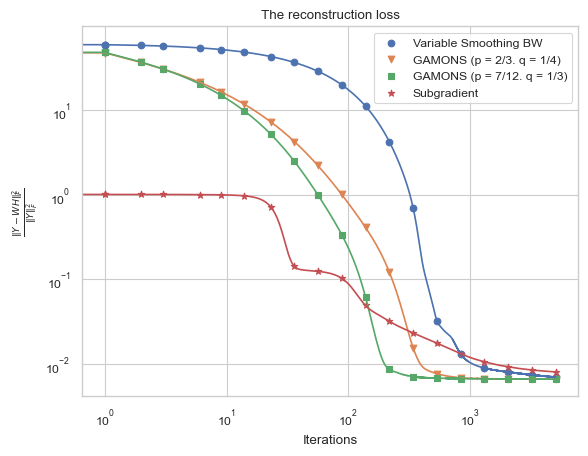

In [11]:
plot_loss(results20)

### Plot the smoothing loss

VS : 1.135e-04
GAMONS (p = 2/3. q = 1/4) : 1.404e-04
GAMONS (p = 7/12. q = 1/3) : 7.934e-05


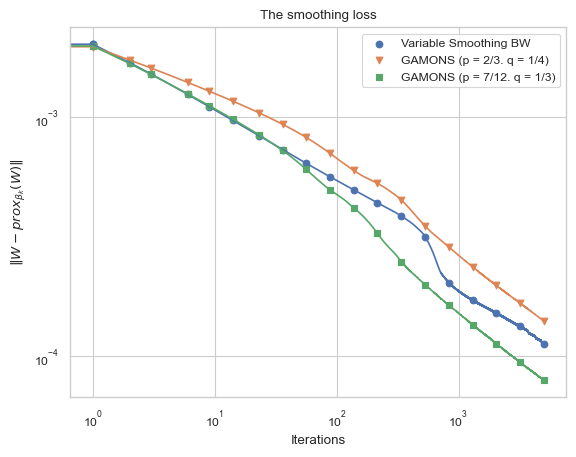

In [12]:
plot_smoothing_loss(results20)

### Plot the primal gap and penalty

VS : -2.889e+04
GAMONS (p = 2/3. q = 1/4) : -2.892e+04
GAMONS (p = 7/12. q = 1/3) : -2.900e+04
[ -6739.47333097  -6761.65813856  -6783.78880776 ... -28826.38155205
 -28826.38575213 -28826.41276962]


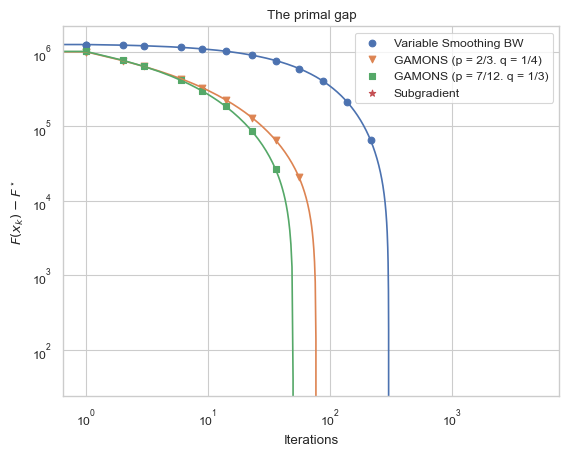

VS : 2.024e+02
GAMONS (p = 2/3. q = 1/4) : 1.811e+02
GAMONS (p = 7/12. q = 1/3) : 1.058e+02


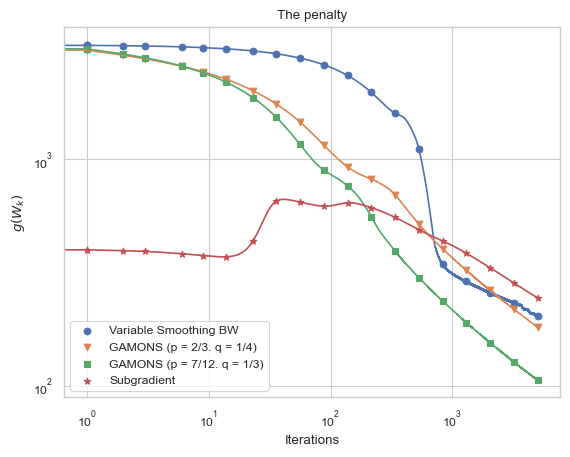

In [13]:
plot_primal_gap_and_penalty(results20)


## Experiments with rank = 30

### Run algorithms

In [14]:
results30 = run_experiment(
    dataset, 
    rank = 30, 
    K = K, 
    g = g, 
    g_torch = g_torch,
    prox = prox,
    store_WH_every = store_WH_every,
)

100%|██████████| 5000/5000 [00:02<00:00, 1942.86it/s]


Gamons (p = 2/3. q = 1/4) loss: 82.24752184128998


100%|██████████| 5000/5000 [00:02<00:00, 1994.53it/s]


Gamons (p = 7/12. q = 1/3) loss: 82.54062072284522


100%|██████████| 5000/5000 [00:02<00:00, 2162.34it/s]


Subgradient descent loss: 145.36952209472656


100%|██████████| 5000/5000 [00:01<00:00, 3402.53it/s]

Variable Smoothing BW loss: 99.38450832825733


### Show the final images

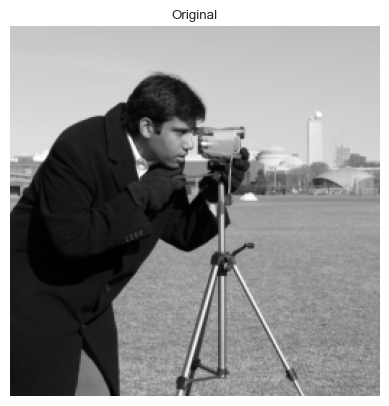

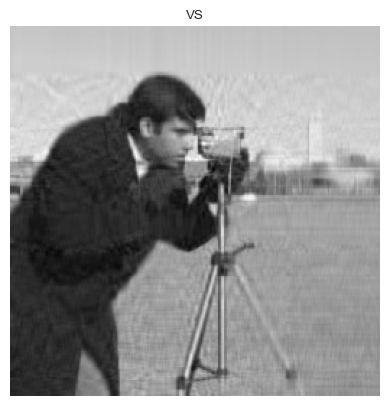

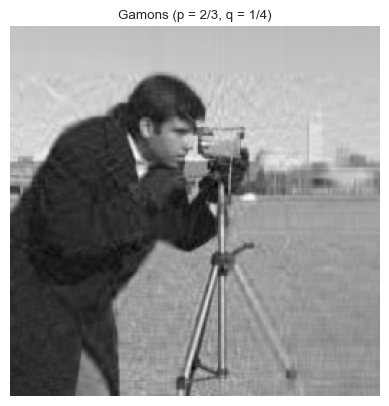

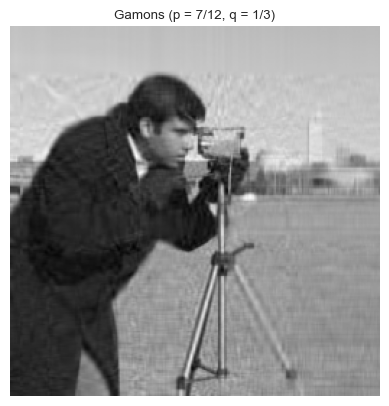

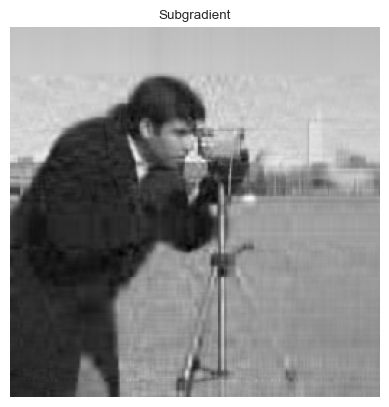

In [15]:
plot_images(results30)

### Plot the reconstruction loss

VS : 4.524e-03
GAMONS (p = 2/3. q = 1/4) : 3.744e-03
GAMONS (p = 7/12. q = 1/3) : 3.758e-03
Subgradient : 6.618e-03


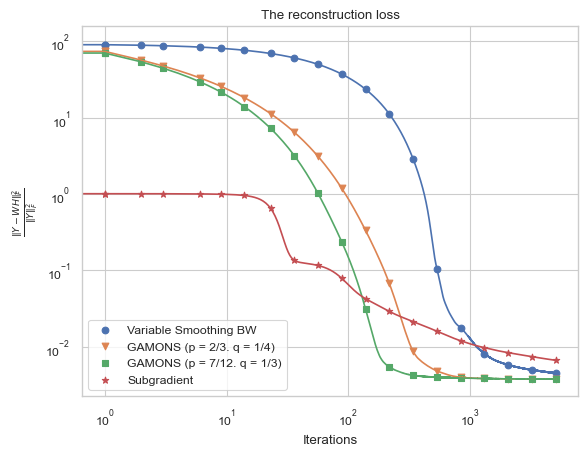

In [16]:
plot_loss(results30)

### Plot the smoothing loss

VS : 1.363e-04
GAMONS (p = 2/3. q = 1/4) : 1.270e-04
GAMONS (p = 7/12. q = 1/3) : 7.788e-05


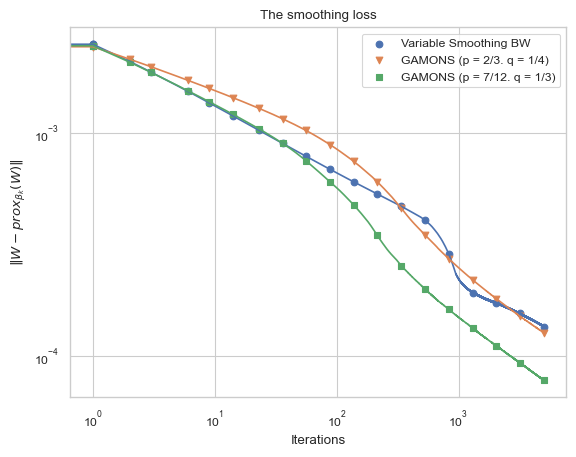

In [17]:
plot_smoothing_loss(results30)

### Plot the primal gap and penalty

VS : -2.889e+04
GAMONS (p = 2/3. q = 1/4) : -2.898e+04
GAMONS (p = 7/12. q = 1/3) : -2.904e+04
[ -6481.55932266  -6513.25793327  -6544.85566889 ... -28837.47817819
 -28837.49856303 -28837.52930929]


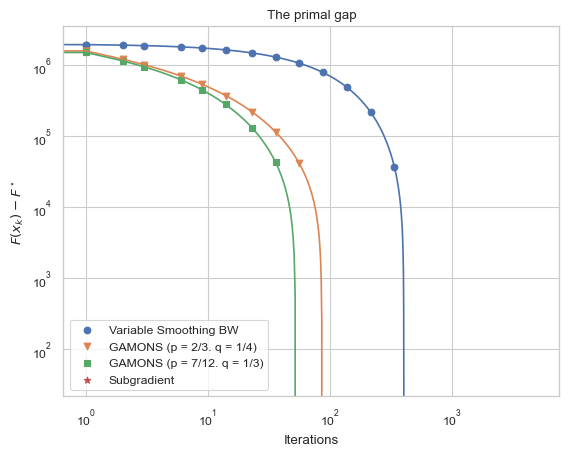

VS : 2.644e+02
GAMONS (p = 2/3. q = 1/4) : 1.910e+02
GAMONS (p = 7/12. q = 1/3) : 1.240e+02


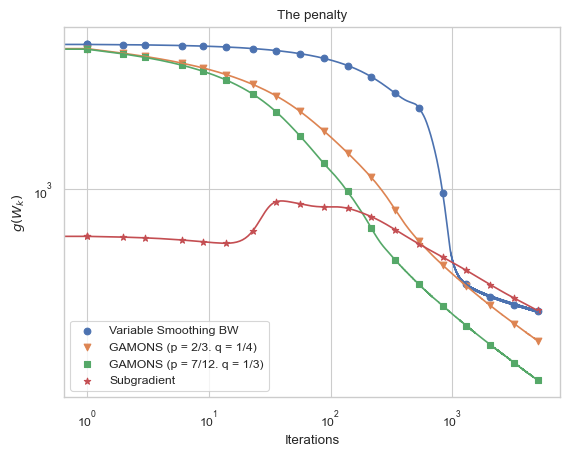

In [18]:
plot_primal_gap_and_penalty(results30)

## Comparison of the images between the ranks

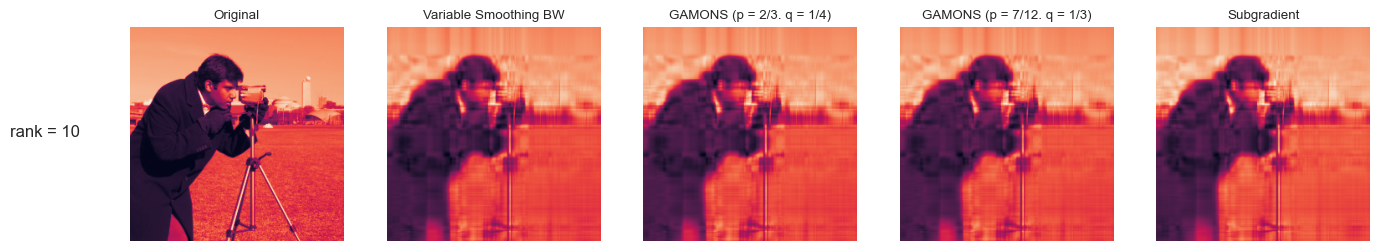

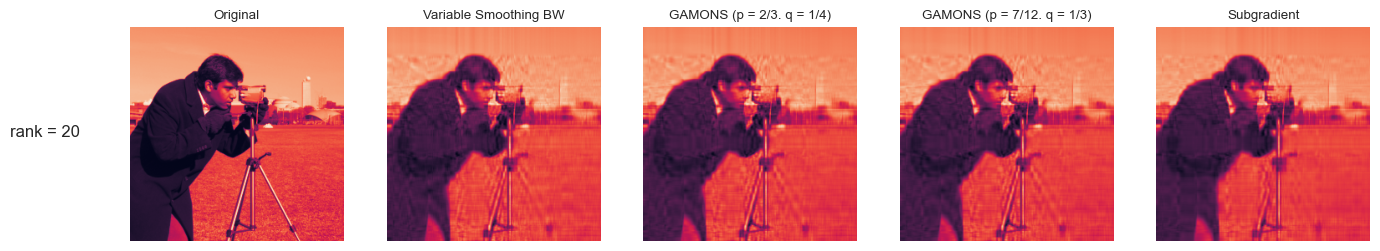

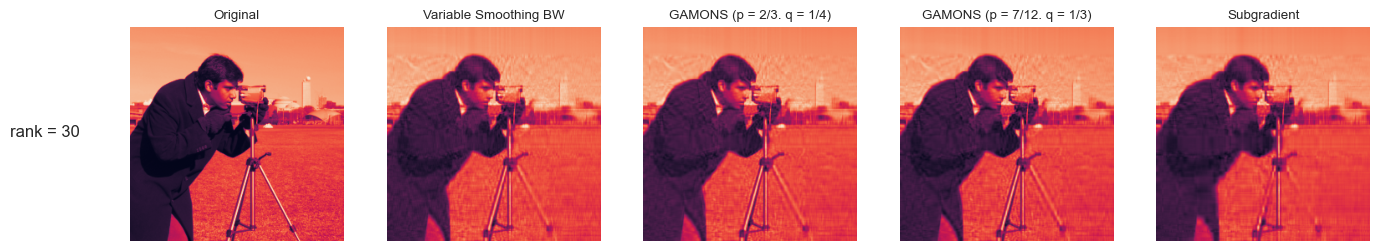

In [ ]:
plot_images_ranks({
    10: results10,
    20: results20,
    30: results30,
})